# Converting speech to written text using deep learning
## Seminar paper: Machine Learning and Intelligent System Control
## Students: Hana Bezdrob & Edvin Teskeredžić
## Year: 2020/2021


The goal of this seminar paper is to demonstrate the use of deep neural networks in simple speech recognition. We develop a network based on:

- DeepSpeech2: https://arxiv.org/abs/1512.02595
- Wav2Letter++: https://arxiv.org/abs/1812.07625

The model is trained and tested on a simple dataset of 10 different commands.

## Import libraries:

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pickle

## Load all data:

In [ ]:
targets = ["left", "go", "yes", "down", "up", "on", "right", "no", "off", "stop"]

In [ ]:
# load from pickle files

x_train = pickle.load(open("xtrain.p", "rb"))
x_test = pickle.load(open("xtest.p", "rb"))
x_valid = pickle.load(open("xvalid.p", "rb"))

y_train = pickle.load(open("ytrain.p", "rb"))
y_test = pickle.load(open("ytest.p", "rb"))
y_valid = pickle.load(open("yvalid.p", "rb"))

print('Shape of train tensor:')
print(x_train.shape)
print('Shape of test tensor:')
print(x_test.shape)
print('Shape of validation tensor:')
print(x_valid.shape)
print('Shape of train labels:')
print(y_train.shape)
print('Shape of test labels:')
print(y_test.shape)
print('Shape of validation labels:')
print(y_valid.shape)

Shape of train tensor:
(12786, 8000, 1)
Shape of test tensor:
(4263, 8000, 1)
Shape of validation tensor:
(4263, 8000, 1)
Shape of train labels:
(12786, 10)
Shape of test labels:
(4263, 10)
Shape of validation labels:
(4263, 10)


## Define model architecture

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

K.clear_session()

model = models.Sequential()


model.add(layers.BatchNormalization(axis=-1, 
                                    momentum=0.99, 
                                    epsilon=1e-3, 
                                    center=True, 
                                    scale=True, 
                                    input_shape=(8000, 1)))

# first conv block
model.add(layers.Conv1D(8, 13, 
                        padding='valid', 
                        activation='relu', 
                        strides=1))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))

# second conv block
model.add(layers.Conv1D(16, 11, 
                        padding='valid', 
                        activation='relu', 
                        strides=1))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))

# third conv block
model.add(layers.Conv1D(32, 9, 
                        padding='valid', 
                        activation='relu', 
                        strides=1))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))


model.add(layers.BatchNormalization(axis=-1, 
                                    momentum=0.99, 
                                    epsilon=1e-3, 
                                    center=True, 
                                    scale=True))

# GRU/RNN layers
model.add(layers.Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
model.add(layers.Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
model.add(layers.Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))

model.add(layers.BatchNormalization(axis=-1, 
                                    momentum=0.99, 
                                    epsilon=1e-3, 
                                    center=True, 
                                    scale=True))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(targets), activation='softmax'))

## Training:

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0

In [ ]:
es = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10, 
                           min_delta=0.0001)

cp = ModelCheckpoint('MIU_model.hdf5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=50, 
    callbacks=[es, cp], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Epoch 1/100
400/400 [==============================] - 864s 2s/step - loss: 4.4548 - accuracy: 0.1207 - val_loss: 2.2765 - val_accuracy: 0.1173

Epoch 00001: val_accuracy improved from -inf to 0.11729, saving model to MIU_model.hdf5
Epoch 2/100
400/400 [==============================] - 851s 2s/step - loss: 2.2417 - accuracy: 0.1346 - val_loss: 2.2571 - val_accuracy: 0.1173

Epoch 00002: val_accuracy did not improve from 0.11729
Epoch 3/100
400/400 [==============================] - 848s 2s/step - loss: 2.1138 - accuracy: 0.1729 - val_loss: 2.5446 - val_accuracy: 0.2137

Epoch 00003: val_accuracy improved from 0.11729 to 0.21370, saving model to MIU_model.hdf5
Epoch 4/100
400/400 [==============================] - 847s 2s/step - loss: 1.5745 - accuracy: 0.3738 - val_loss: 1.5394 - val_accuracy: 0.4122

Epoch 00004: val_accuracy improved from 0.21370 to 0.41215, saving model to MIU_model.hdf5
Epoch 5/100
400/400 [==============================] - 848s 2s/step - loss: 1.2187 - accuracy: 

In [ ]:
# save all data using pickle (only used on first run)
pickle.dump(x_train, open( "xtrain.p", "wb" ))

In [ ]:
pickle.dump(y_train, open( "ytrain.p", "wb" ))

In [ ]:
pickle.dump(x_valid, open( "xvalid.p", "wb" ))

In [ ]:
pickle.dump(y_valid, open( "yvalid.p", "wb" ))

In [ ]:
pickle.dump(x_test, open( "xtest.p", "wb" ))

In [ ]:
pickle.dump(y_test, open( "ytest.p", "wb" ))

## Performance evaluation:

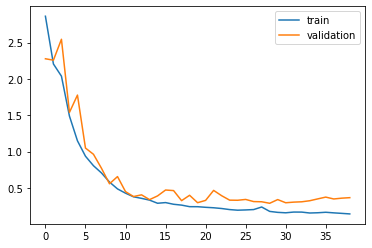

In [ ]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

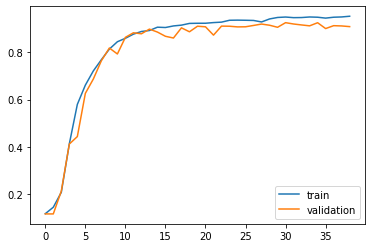

In [ ]:
from matplotlib import pyplot
pyplot.plot(hist.history['accuracy'], label='train')
pyplot.plot(hist.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

## Accuracy over test set:

In [ ]:
def predictMIU(audio):
    p = model.predict(audio.reshape(1, 8000, 1))
    index = np.argmax(p[0])
    return targets[index]

In [ ]:
total = len(x_test)
correct = 0
for i in range(len(x_test)):
  samples = x_test[i].ravel()
  if (classes[np.argmax(y_test[i])] == predictMIU(samples)):
    correct = correct + 1

print("Accuracy over test set: ", correct / total * 100.)

Accuracy over test set:  90.66385174759559
